In [7]:
%matplotlib inline

import pydicom as dicom
import numpy as np
import cmath
import math
import scipy
import os, sys
import matplotlib
import scipy.ndimage
import pickle

matplotlib.use("Qt5Agg")

import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.mlab import dist_point_to_segment

In [8]:
a = 'lge_lv.pkl'

data = pickle.load(open(a, 'rb'))

lge_img = data['lge_img']
mask_myoseg = data['mask_myoseg']
spacing_btw_slices = data['spacingbetweenslices']
mask_scar = data['mask_scar_nSD']
slicelocation = data['slicelocation']
pixelspacing = data['pixelspacing']

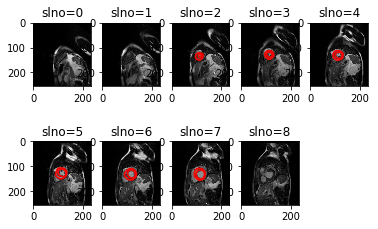

In [9]:
# display

#print(lge_img.shape)

nslice = lge_img.shape[2]

plt.figure()
for slno in range(nslice):
    plt.subplot(2, 5, slno+1)
    plt.imshow(lge_img[:,:,slno], cmap='gray')
    plt.contour(mask_myoseg[:,:,slno], [0.5], colors='r')
    plt.title('slno=%d' % slno)
    
plt.show()

In [11]:
# slice assignment to Basal, Mid, Apical

basal_sIdx = 6
basal_eIdx = 7
mid_sIdx = 4
mid_eIdx = 5
apical_sIdx = 2
apical_eIdx = 3

basal_slices = np.array([6, 7])
mid_slices = np.array([4, 5])
apical_slices = np.array([2, 3])

In [ ]:
# LV center, RV insert 선택

pts = {}

for j in range(apical_slices[0], basal_slices[-1]+1, 1):
    plt.figure()
    plt.imshow(lge_img[:,:,j], cmap='gray')
    #print('LV center followed by RV insert')
    x = plt.ginput(2)
    #print('clicked = ', x)
    pts[j] = x
    
x1 = pts[3][0]  # LV center
x2 = pts[3][1]  # RV insert

print('LV center = ', x1)
print('RV insert = ', x2)

In [ ]:
# transformation to polar coordinate

FETCHLENGTH = 70
def fetchImageFromCoors_yck(img, coords):
    coords = np.array(coords)

    height = FETCHLENGTH
    gluedImage = np.zeros((height, len(coords)))
    
    for idx, coord in enumerate(coords):
        for part in range(height):
            try:
                imageCoord = (1 - part/height) * coord[0] + (part/height) * coord[1]
                gluedImage[part, idx] = img[int(np.rint(imageCoord[0])), int(np.rint(imageCoord[1]))]
            except:
                None
                
    return gluedImage

In [ ]:
import scipy.ndimage

# transformation to polar coordinate

FETCHLENGTH = 70
def fetchImageFromCoors_yck2(img, coords):
    coords = np.array(coords)
#     print(coords, len(coords))
#     height = FETCHLENGTH
    num = 140   # FETCHLENGTH보다 길게 한다. interpolation됨.
    gluedImage = np.zeros((num, len(coords)))
    for idx, coord in enumerate(coords):
#         x0, y0 = coord[0][1], coord[0][0]
#         x1, y1 = coord[1][1], coord[1][0]
        x0, y0 = coord[0][0], coord[0][1]
        x1, y1 = coord[1][0], coord[1][1]
#         if idx == 0:
#             print('좌표점, x,y coordinate')
#             print(coord)
#             print(x0, y0)
#             print(x1, y1)
        x, y = np.linspace(x0,x1,num), np.linspace(y0,y1,num)
        gluedImage[:, idx] = scipy.ndimage.map_coordinates(img, np.vstack((x,y)))

    return gluedImage

In [9]:
def transform_polar_yck(img, LVseed, RVseed):
    
    destination = []

    zref = complex(1, 0)
    zLVseed = complex(LVseed[0], LVseed[1])
    zRVseed = complex(RVseed[0], RVseed[1])
    ztarget = zRVseed - zLVseed
    angle = cmath.phase(ztarget/zref) * 180 / math.pi

    for i in range(0, 360):
        vec = np.array([math.cos( (i+angle)/180*math.pi), math.sin( (i+angle)/180*math.pi)])
        destination.append( [LVseed, LVseed + vec*FETCHLENGTH] )
        
    gluedImage = fetchImageFromCoors_yck2(img, destination)
    
    return gluedImage

In [10]:
slno = 7

img = lge_img[:, :, slno]
mask = mask_myoseg[:,:,slno]
scar = mask_scar[:,:,slno,1]

x1 = pts[slno][0]
x2 = pts[slno][1]

LVseed = (x1[1], x1[0])
RVseed = (x2[1], x2[0])

zref = complex(1, 0)

zLVseed = complex(x1[1], x1[0])
zRVseed = complex(x2[1], x2[0])

ztarget = zRVseed - zLVseed

angle = cmath.phase(ztarget/zref) * 180 / math.pi

# print(angle)

# polar coordinate transformation  수행
polar_image = transform_polar_yck(img, LVseed, RVseed)
polar_mask = transform_polar_yck(mask, LVseed, RVseed)
polar_scar = transform_polar_yck(scar, LVseed, RVseed)

(256, 232, 9, 5)


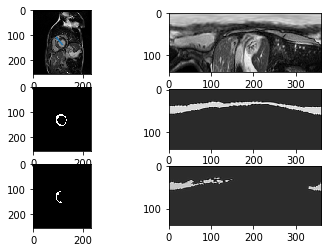

In [11]:
plt.figure()

plt.subplot(321)
plt.imshow(img, cmap='gray')
plt.plot([x1[0], x2[0]], [x1[1], x2[1]])

plt.subplot(322)
plt.imshow(polar_image, cmap='gray')

plt.subplot(323)
plt.imshow(mask, cmap='gray')

plt.subplot(324)
plt.imshow(polar_mask, cmap='gray')

plt.subplot(325)
plt.imshow(scar, cmap='gray')

plt.subplot(326)
plt.imshow(polar_scar, cmap='gray')

plt.show()

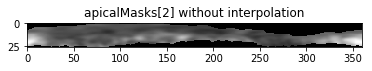

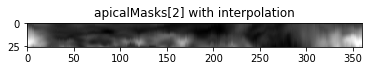

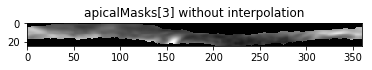

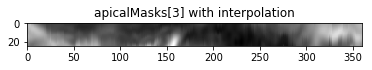

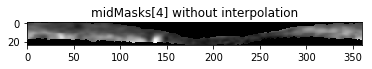

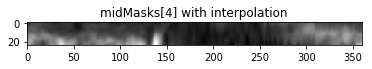

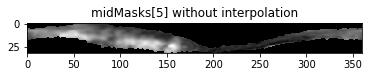

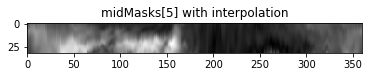

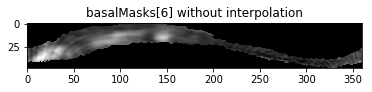

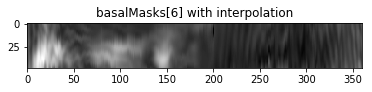

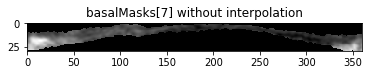

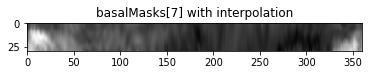

In [13]:
# make the myocardial thickness the same in all angles.
# if more than one slice belong to 'basal' (or 'mid', or 'apical'), divide the ring into the number of slices. 
# transform and display it in 16-segment AHA model!!!

def get_xyposition_fromMask(mask):
    position = np.where(mask >= 1)
    return position

def get_myocardial_mask(whichMask, start_idx, end_idx):
    result = []
    without_extra_result = [] # interpolation 기법 찾으면 지우기
    for i in range(start_idx, end_idx + 1):
        img = lge_img[:, :, i]
        mask = mask_myoseg[:,:,i]
        scar = mask_scar[:,:,i,1]

        x1 = pts[i][0]
        x2 = pts[i][1]

        LVseed = (x1[1], x1[0])
        RVseed = (x2[1], x2[0])

        zref = complex(1, 0)

        zLVseed = complex(x1[1], x1[0])
        zRVseed = complex(x2[1], x2[0])

        ztarget = zRVseed - zLVseed

        angle = cmath.phase(ztarget/zref) * 180 / math.pi
        polar_image = transform_polar_yck(img, LVseed, RVseed)
        polar_mask = transform_polar_yck(mask, LVseed, RVseed)
        bin_polar_mask = np.where(polar_mask > 0.5, 1, 0)  # binary image of polar_mask

        xypos = get_xyposition_fromMask(bin_polar_mask)
        ypos = xypos[0]

        min_x = 0
        min_y = np.min(ypos)
        max_x = bin_polar_mask.shape[1]
        max_y = np.max(ypos)
        
        real_polar_mask = np.multiply(polar_image, bin_polar_mask)  # element-wise vector multiplication
        bin_polar_mask = bin_polar_mask[min_y : max_y, min_x : max_x]
        real_polar_mask = real_polar_mask[min_y : max_y, min_x : max_x]
        
        plt.figure()
        plt.imshow(real_polar_mask, cmap='gray')
        plt.title(whichMask + "[%d]" % i + " without interpolation")
        plt.show()
        
        without_extra_result.append(np.copy(real_polar_mask)) # interpolation 기법 찾으면 지우기

        for x in range(min_x, max_x):
            pos = np.where(bin_polar_mask[:, x] >= 1)
            min_edge_y = np.min(pos)
            max_edge_y = np.max(pos)
            
            f = scipy.interpolate.interp1d(np.arange(min_edge_y, max_edge_y), \
                                           real_polar_mask[min_edge_y : max_edge_y, x])
            
            real_polar_mask[:, x] = f(np.linspace(min_edge_y, max_edge_y - 1, max_y - min_y))
            # interpolation 함수는 내부의 값만 찾을 수 있다. 따라서 끝점에서 -1해줘야 한다.

        plt.figure()
        plt.imshow(real_polar_mask, cmap='gray')
        plt.title(whichMask + "[%d]" % i + " with interpolation")
        plt.show()

        result.append(real_polar_mask)
        
    return result, without_extra_result # interpolation 기법 찾으면 지우기

apicalMasks, without_extra_apicalMasks = get_myocardial_mask("apicalMasks", apical_sIdx, apical_eIdx)
midMasks, without_extra_midMasks = get_myocardial_mask("midMasks", mid_sIdx, mid_eIdx)
basalMasks, without_extra_basalMasks = get_myocardial_mask("basalMasks", basal_sIdx, basal_eIdx)

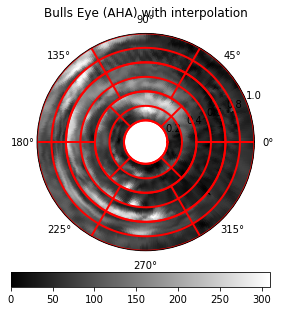

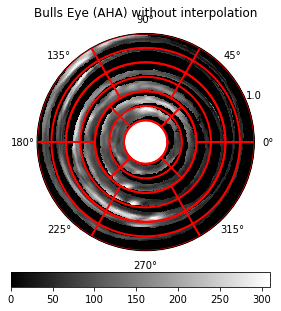

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def bullseye_plot(ax, cax, apicalMasks, midMasks, basalMasks, 
                  cmap=None, linewidth=2):

    if cmap is None:
        cmap = plt.cm.viridis
    
    minVals = []
    maxVals = []
        
    # suppose that all shape of masks are the same
    theta = np.linspace(0, 2 * np.pi, apicalMasks[0].shape[1])  # 0 ~ 2 * pi
    r = np.linspace(0.2, 1, 4)
    rApical = np.linspace(r[0], r[1], len(apicalMasks) + 1)
    rMid = np.linspace(r[1], r[2], len(midMasks) + 1)
    rBasal = np.linspace(r[2], r[3], len(basalMasks) + 1)
    
    # Create the bound for the segment 17
    for i in range(r.shape[0]):
        ax.plot(theta, np.repeat(r[i], theta.shape), '-r', lw=linewidth)

    for i in range(len(apicalMasks)):
        ax.plot(theta, np.repeat(rApical[i], theta.shape), '-r', lw=linewidth)
    
    for i in range(len(midMasks)):
        ax.plot(theta, np.repeat(rMid[i], theta.shape), '-r', lw=linewidth)
        
    for i in range(len(basalMasks)):
        ax.plot(theta, np.repeat(rBasal[i], theta.shape), '-r', lw=linewidth)
        
    # Create the bounds for the segments 1-12
    for i in range(6):
        theta_i = np.deg2rad(i * 60)
        ax.plot([theta_i, theta_i], [r[1], 1], '-r', lw=linewidth)
        
    # Create the bounds for the segments 13-16
    for i in range(4):
        theta_i = np.deg2rad(i * 90 - 45)
        ax.plot([theta_i, theta_i], [r[0], r[1]], '-r', lw=linewidth)

    for i in range(len(apicalMasks)):
        r0 = np.linspace(rApical[i], rApical[i + 1], apicalMasks[i].shape[0])
        theta0, r0 = np.meshgrid(theta + np.deg2rad(90), r0)
        ax.pcolormesh(theta0, r0, apicalMasks[i], cmap=cmap)
        minVals.append(apicalMasks[i].min())
        maxVals.append(apicalMasks[i].max())
        
    for i in range(len(midMasks)):
        r0 = np.linspace(rMid[i], rMid[i + 1], midMasks[i].shape[0])
        theta0, r0 = np.meshgrid(theta + np.deg2rad(120), r0)  
        ax.pcolormesh(theta0, r0, midMasks[i], cmap=cmap)
        minVals.append(midMasks[i].min())
        maxVals.append(midMasks[i].max())
    
    for i in range(len(basalMasks)):
        r0 = np.linspace(rBasal[i], rBasal[i + 1], basalMasks[i].shape[0])
        theta0, r0 = np.meshgrid(theta + np.deg2rad(120), r0)
        ax.pcolormesh(theta0, r0, basalMasks[i], cmap=cmap)
        minVals.append(basalMasks[i].min())
        maxVals.append(basalMasks[i].max())

    norm = mpl.colors.Normalize(vmin=min(minVals), vmax=max(maxVals))
    mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                              orientation='horizontal')
    
# Make a figure and axes with dimensions as desired.
fig1, ax1 = plt.subplots(subplot_kw=dict(projection='polar'))
cax1 = fig1.add_axes([0.2, 0.0, 0.6, 0.05])

# Create the 17 segment model
bullseye_plot(ax1, cax1, apicalMasks, midMasks, basalMasks, cmap='gray')
ax1.set_title('Bulls Eye (AHA) with interpolation')

# Make a figure and axes with dimensions as desired.
fig2, ax2 = plt.subplots(subplot_kw=dict(projection='polar'))
cax2 = fig2.add_axes([0.2, 0.0, 0.6, 0.05])

# Create the 17 segment model
bullseye_plot(ax2, cax2, without_extra_apicalMasks, without_extra_midMasks, without_extra_basalMasks, cmap='gray')
ax2.set_title('Bulls Eye (AHA) without interpolation')

plt.show()